In [16]:
import os, pickle
import numpy as np


# ------------------------------------------------------------
# Load the processed, cropped data dict produced earlier
# ------------------------------------------------------------
pickle_path = 'output/processed_data_ori.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError(f"Processed data not found at {pickle_path}")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# ------------------------------------------------------------
# Build the big data matrix X  (rows = slices, cols = time-bins)
# ------------------------------------------------------------
X_list, sample_tag = [], []
time_axis = None

for name, df in data_dict.items():
    if time_axis is None:
        time_axis = df['Time'].to_numpy(dtype=float)

    slice_cols  = df.columns.difference(['Time_index', 'Time'])
    mat         = df[slice_cols].to_numpy(dtype=float)      # (n_time, n_slices)
    X_list.append(mat.T)                                    # -> (n_slices, n_time)
    sample_tag.extend([name] * mat.shape[1])

X           = np.vstack(X_list)
n_slices, n_time = X.shape
print("Combined data matrix shape:", X.shape)

Combined data matrix shape: (216, 389)


Estimated taus: [  0.58678818   5.12556015 535.21402972]


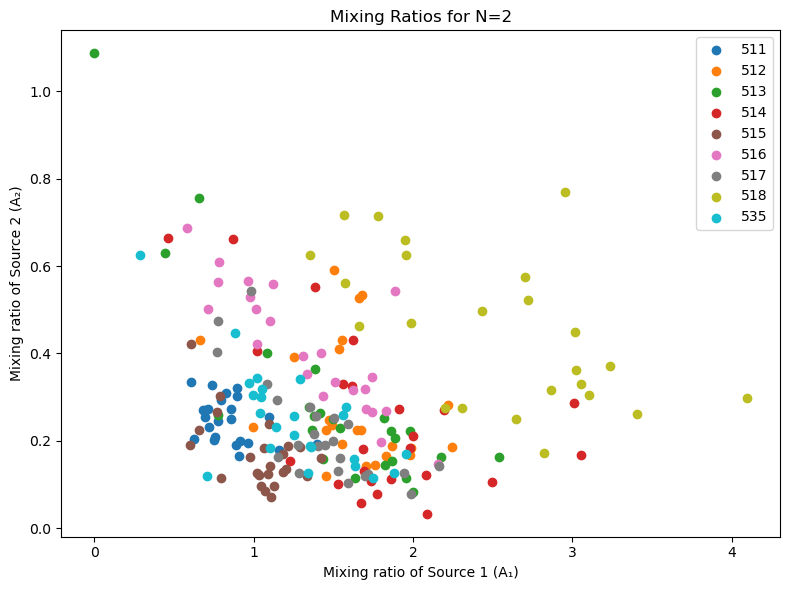

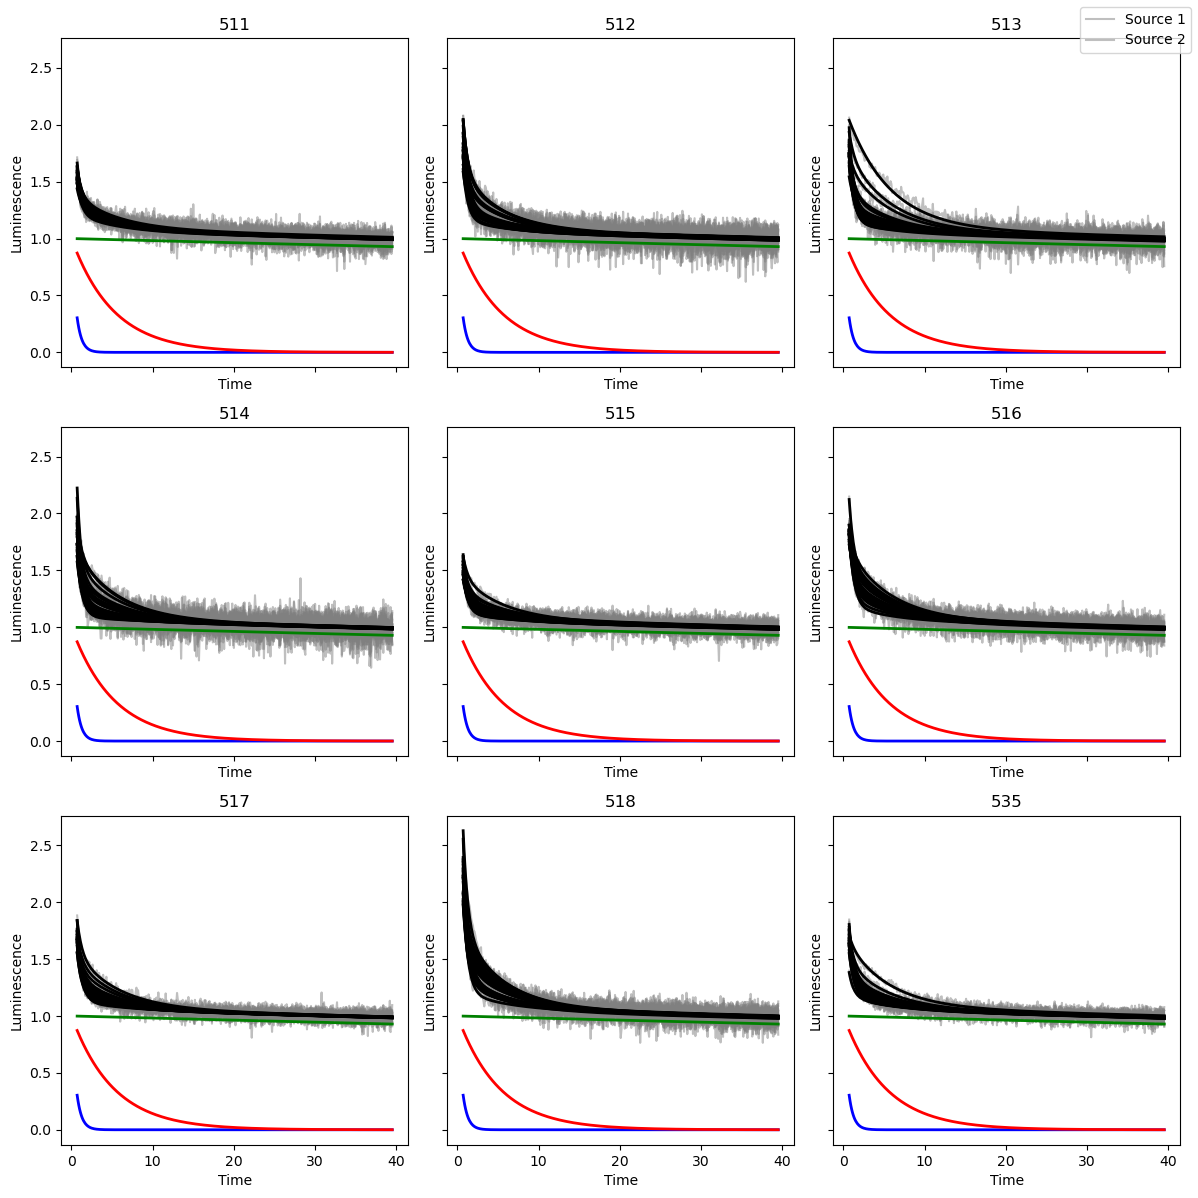

In [17]:
import os
import pickle
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Load your data
# ------------------------------------------------------------
pickle_path = 'output/processed_data.pkl'   # adjust if needed
if not os.path.exists(pickle_path):
    raise FileNotFoundError(f"Processed data not found at {pickle_path}")
with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# Build X (M slices × T time-bins), sample_tag list, and time_axis
X_list, sample_tag = [], []
time_axis = None
for name, df in data_dict.items():
    if time_axis is None:
        time_axis = df['Time'].to_numpy(dtype=float)
    slice_cols = df.columns.difference(['Time_index','Time'])
    mat = df[slice_cols].to_numpy(dtype=float)      # (T, n_slices)
    X_list.append(mat.T)                             # -> (n_slices, T)
    sample_tag.extend([name] * mat.shape[1])
X = np.vstack(X_list)  # shape (M, T)
sample_tag = np.array(sample_tag)
t = time_axis
M, T = X.shape

# ------------------------------------------------------------
# 2. Fit global 2-exponential model
#    d_j(t) ≈ A_{j1} e^{−t/τ1} + A_{j2} e^{−t/τ2}
# ------------------------------------------------------------
# N = 2

# def residuals(p):
#     taus = p[:N]
#     A = p[N:].reshape(M, N)
#     # source curves S_i(t) = exp(−t/τ_i)
#     S = np.exp(-np.outer(1/taus, t))   # (N, T)
#     D_hat = A.dot(S)                   # (M, T)
#     return (D_hat - X).ravel()

# # initial guesses
# tau0 = np.array([t.mean(), 2*t.mean()])
# A0 = np.tile(np.mean(X, axis=1, keepdims=True), (1, N)) / N
# p0 = np.hstack([tau0, A0.ravel()])

# # enforce τ>0 and A>=0
# lower = np.hstack([[1e-6]*N, np.zeros(M*N)])
# upper = np.inf * np.ones_like(p0)

# sol = least_squares(residuals, p0, bounds=(lower,upper))
# taus_est = sol.x[:N]
# A_est = sol.x[N:].reshape(M, N)

# print(f"Estimated time constants: τ₁ = {taus_est[0]:.2f},  τ₂ = {taus_est[1]:.2f}")




N = 3

def residuals(p):
    taus = p[:N]
    A = p[N:].reshape(M, N)
    # pure-source decays
    S = np.exp(-np.outer(1/taus, t))   # (N, T)
    D_hat = A.dot(S)                   # (M, T)
    return (D_hat - X).ravel()

# 1) initial guesses for τ (length N)
tau0 = np.array([t.mean(), 2*t.mean(), 3*t.mean()])

# 2) initial guesses for A (shape M×N)
A0 = np.tile(np.mean(X, axis=1, keepdims=True), (1, N)) / N

# 3) stack into p0 of length N + M*N
p0 = np.hstack([tau0, A0.ravel()])

# 4) bounds of same shape as p0
lower = np.hstack([[1e-6]*N, np.zeros(M*N)])
upper = np.inf * np.ones_like(p0)

# 5) solve
sol = least_squares(residuals, p0, bounds=(lower, upper))
taus_est = sol.x[:N]
A_est    = sol.x[N:].reshape(M, N)

print(f"Estimated taus: {taus_est}")

# ------------------------------------------------------------
# 3. Scatter plot of mixing ratios (A₁ vs. A₂), colored by sample
# ------------------------------------------------------------
unique_samples = np.unique(sample_tag)
colors = plt.cm.tab10(np.linspace(0,1,len(unique_samples)))

plt.figure(figsize=(8,6))
for c, s in zip(colors, unique_samples):
    mask = (sample_tag == s)
    plt.scatter(A_est[mask,0], A_est[mask,1], label=s, color=c)
plt.xlabel('Mixing ratio of Source 1 (A₁)')
plt.ylabel('Mixing ratio of Source 2 (A₂)')
plt.title('Mixing Ratios for N=2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. 3×3 subplots: raw slices (grey) + two source curves
# ------------------------------------------------------------
S_est = np.exp(-np.outer(1/taus_est, t))  # (2, T)

fig, axs = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)
for ax, s in zip(axs.ravel(), unique_samples):
    mask = (sample_tag == s)
    # raw curves
    for j in np.where(mask)[0]:
        ax.plot(t, X[j], color='grey', alpha=0.5)
    # overlaid sources
    ax.plot(t, S_est[0], color='blue',  lw=2, label='Source 1')
    ax.plot(t, S_est[1], color='red',   lw=2, label='Source 2')
    ax.plot(t, S_est[2], color='green', lw=2, label='Source 3')

    # plot the sum of the sources
    ax.plot(t, A_est[mask].dot(S_est).T, color='black', lw=2, label='Sum of Sources')
    

    ax.set_title(s)
    ax.set_xlabel('Time')
    ax.set_ylabel('Luminescence')

# shared legend for the two sources
fig.legend(['Source 1','Source 2'], loc='upper right')
plt.tight_layout()
plt.show()


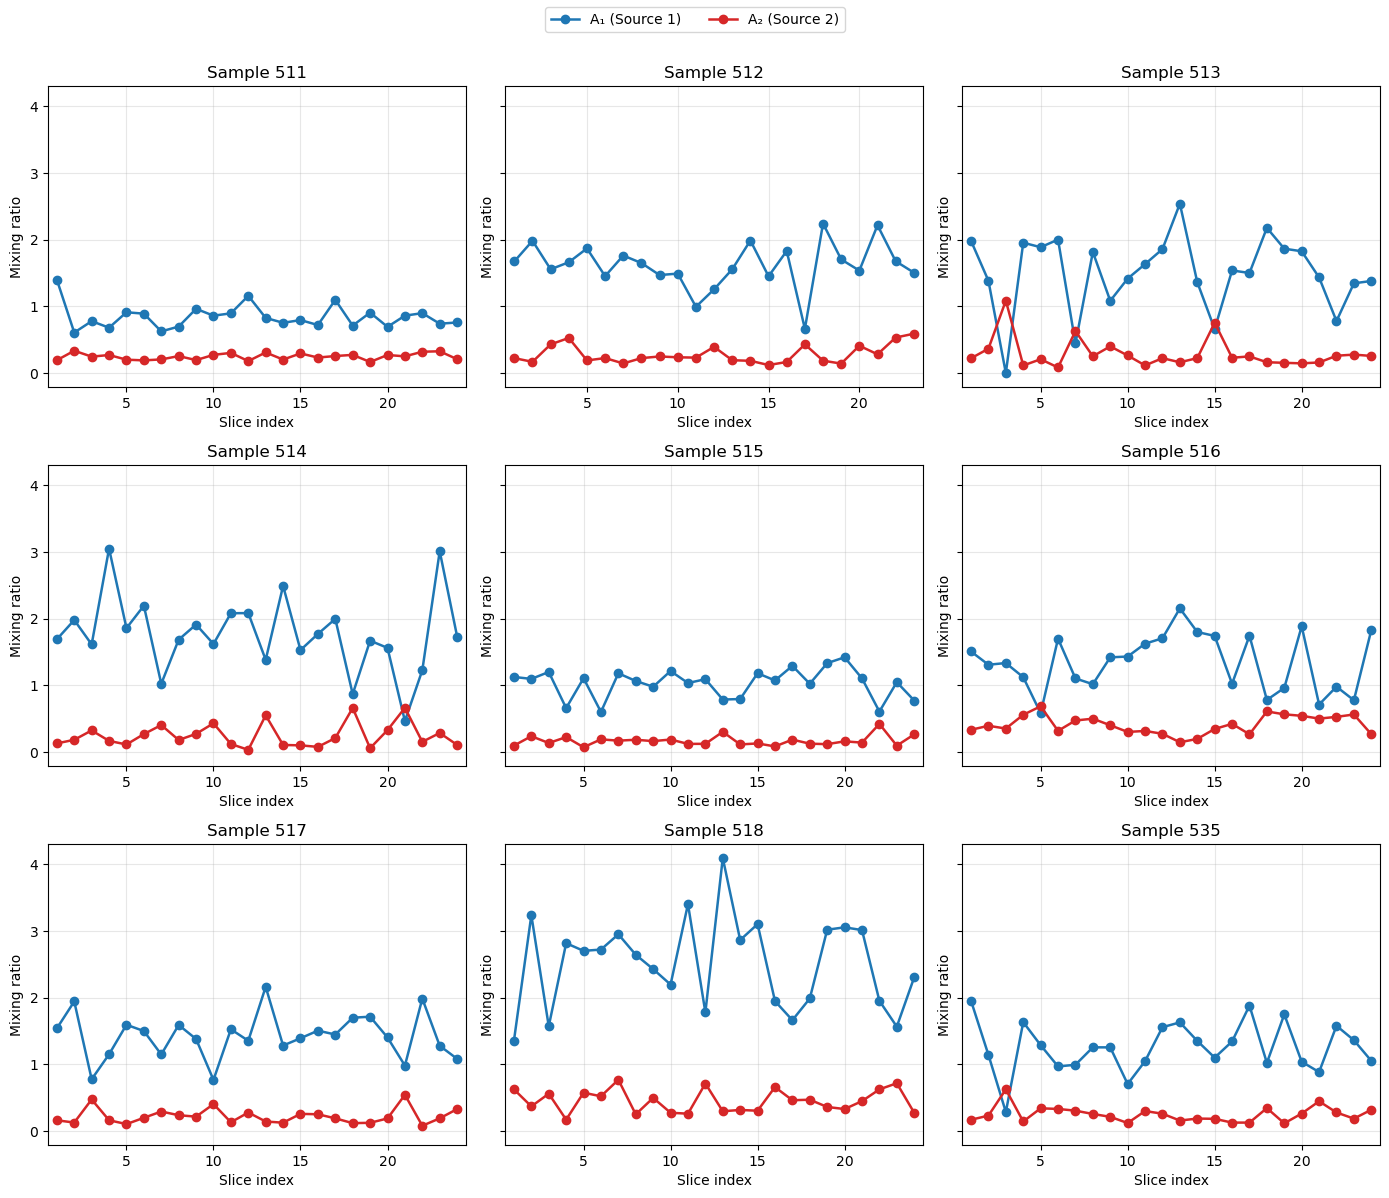

In [18]:
# ------------------------------------------------------------------
# 3×3 grid – how A₁ and A₂ vary from slice to slice inside each sample
# ------------------------------------------------------------------
unique_samples = np.unique(sample_tag)
n_rows, n_cols = 3, 3
fig, axes      = plt.subplots(n_rows, n_cols, figsize=(14, 12),
                              sharex=False, sharey=True)

for ax, s in zip(axes.ravel(), unique_samples):
    mask        = (sample_tag == s)
    A_sample    = A_est[mask]                 # (n_slices_in_sample × 3)
    n_slices    = A_sample.shape[0]
    x_idx       = np.arange(1, n_slices+1)    # 1‑based slice index

    # plot A1 and A2 as two coloured lines
    ax.plot(x_idx, A_sample[:, 0], '-o',  lw=1.8, color='tab:blue',
            label='A₁ (Source 1)')
    ax.plot(x_idx, A_sample[:, 1], '-o',  lw=1.8, color='tab:red',
            label='A₂ (Source 2)')

    ax.set(title=f'Sample {s}',
           xlabel='Slice index', ylabel='Mixing ratio')
    ax.set_xlim(0.5, n_slices+0.5)
    ax.grid(alpha=0.3)

# turn off any unused axes if fewer than 9 samples
for ax in axes.ravel()[len(unique_samples):]:
    ax.axis('off')

# one common legend outside the grid
fig.legend(['A₁ (Source 1)', 'A₂ (Source 2)'],
           loc='upper center', ncol=2, fontsize='medium')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_

GMM selected 2 components (lowest BIC = 184.3)


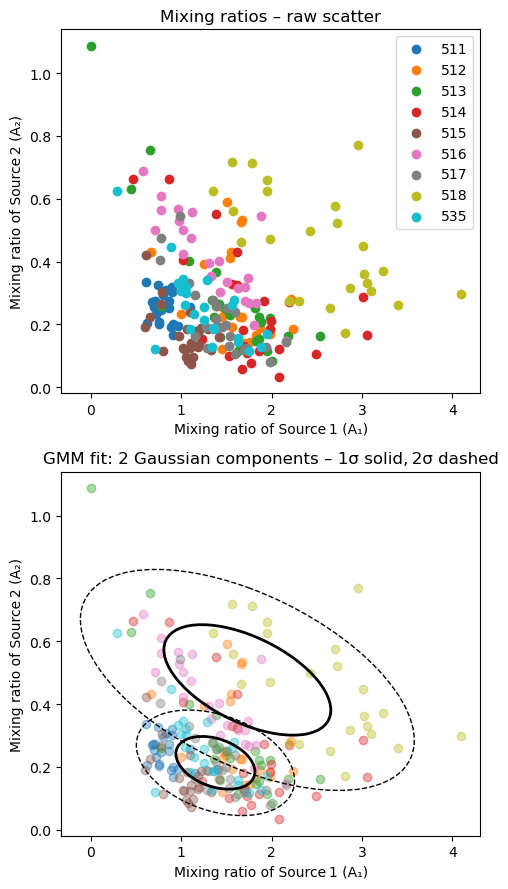

In [9]:
# ------------------------------------------------------------
# Fit a Gaussian‑mixture model to the (A₁ , A₂) cloud
# ------------------------------------------------------------
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

# 1. 2‑D data matrix (rows = slices, cols = the two mixing ratios)
X_2d = A_est[:, :2]          # shape (M, 2)

# 2. model‑selection sweep (1–7 components) using BIC
bic_vals, gmms = [], []
for k in range(1, 8):
    gmm_k = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0
    ).fit(X_2d)
    bic_vals.append(gmm_k.bic(X_2d))
    gmms.append(gmm_k)

best_idx = int(np.argmin(bic_vals))
gmm      = gmms[best_idx]
print(f'GMM selected {gmm.n_components} components (lowest BIC = {bic_vals[best_idx]:.1f})')

# 3. helper – add n‑σ ellipses of each Gaussian to an axis
def draw_gmm_ellipses(ax, gmm, n_sigma=1, **kwargs):
    for mean, cov in zip(gmm.means_, gmm.covariances_):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        width, height = 2 * n_sigma * np.sqrt(vals)   # 2 σ (full width)
        ell = Ellipse(
            xy=mean,
            width=width,
            height=height,
            angle=angle,
            **kwargs
        )
        ax.add_patch(ell)

# 4. figure: (top) original scatter, (bottom) scatter + ellipses
fig = plt.figure(figsize=(5, 9))

# 4a) original scatter
ax0 = fig.add_subplot(2, 1, 1)
for c, s in zip(colors, unique_samples):
    mask = (sample_tag == s)
    ax0.scatter(A_est[mask, 0], A_est[mask, 1], color=c, label=s)
ax0.set_xlabel('Mixing ratio of Source 1 (A₁)')
ax0.set_ylabel('Mixing ratio of Source 2 (A₂)')
ax0.set_title('Mixing ratios – raw scatter')
ax0.legend(loc='best')

# 4b) scatter + GMM contours
ax1 = fig.add_subplot(2, 1, 2, sharex=ax0, sharey=ax0)
for c, s in zip(colors, unique_samples):
    mask = (sample_tag == s)
    ax1.scatter(A_est[mask, 0], A_est[mask, 1], color=c, alpha=0.4)\

draw_gmm_ellipses(ax1, gmm, n_sigma=1, lw=2, edgecolor='black', facecolor='none')
draw_gmm_ellipses(ax1, gmm, n_sigma=2, lw=1, ls='--', edgecolor='black', facecolor='none')
ax1.set_xlabel('Mixing ratio of Source 1 (A₁)')
ax1.set_ylabel('Mixing ratio of Source 2 (A₂)')
# ax1.legend(loc='best')
ax1.set_title(f'GMM fit: {gmm.n_components} Gaussian component'
              + ('s' if gmm.n_components > 1 else '')
              + ' – 1σ solid, 2σ dashed')

fig.tight_layout()
plt.show()


# 518 和 516 物源类似
# 其他所有样品物源类似